# Microgrid in Japan - Graphs of production/consumption of electricity

https://www.nature.com/articles/sdata201920?fbclid=IwAR3qOLHs0Ra5HNiXr3GZt5BdkG56WryLDnubRFd21lil12LAQXJlzb0tTT8

In [15]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
import glob
import pandas as pd
#sys.path.insert(0, '../')
import datetime
import numpy as np
import multiprocessing as mp

## 0. Season definition

In [49]:
# Japan is Northern Hemisphere
start_month = {'winter' : 12, 'spring': 3, 'summer': 6, 'autumn': 9}
end_month = {'winter' : 2, 'spring': 5, 'summer': 8, 'autumn' : 11}

In [60]:
# Percentile 10%
def q10(x):
    return x.quantile(0.1)

# Percentile 90%
def q90(x):
    return x.quantile(0.9)

## 1. Load pre-processed dataset files containing power values with 5 min resolution

In [11]:
def load_dataset(path):
    df = pd.read_csv(path).set_index('timestamp')
    return df

In [16]:
def parallelize_dataframe_processing(file_list, func, n_cores=16):
    pool = mp.Pool(n_cores)
    df = pd.concat(pool.map(func, file_list))
    pool.close()
    pool.join()
    return df

In [17]:
dataset_treated_dir = os.path.join(os.getcwd(), 'scenarios')
print("dataset_treated_dir: " + dataset_treated_dir)
file_list = glob.glob(os.path.join(str(dataset_treated_dir), '*_5m_*.csv.gz'))
df = parallelize_dataframe_processing(file_list, load_dataset)
df.head(4)

dataset_treated_dir: /projetos/CZT0/doutorado_files/microgrid/scenarios
                     Active power of the battery (kW)  \
timestamp                                               
2015-04-25 00:00:00                          -0.88400   
2015-04-25 00:05:00                          -0.86725   
2015-04-25 00:10:00                          -0.87050   
2015-04-25 00:15:00                          -0.86675   

                     Direct voltage of the battery (V)  \
timestamp                                                
2015-04-25 00:00:00                         344.981073   
2015-04-25 00:05:00                         344.857349   
2015-04-25 00:10:00                         344.827050   
2015-04-25 00:15:00                         344.745829   

                     Direct current of the battery (A)  \
timestamp                                                
2015-04-25 00:00:00                          -0.531250   
2015-04-25 00:05:00                          -0.402083   
2015

In [20]:
df = df.drop(columns=['Unnamed: 13', 'Unnamed: 14'])

In [37]:
df['Building_Consumption'] *= -1

In [51]:
df.index = pd.DatetimeIndex(df.index)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348480 entries, 2015-04-25 00:00:00 to 2018-03-24 23:55:00
Data columns (total 12 columns):
 #   Column                                                           Non-Null Count   Dtype  
---  ------                                                           --------------   -----  
 0   Active power of the battery (kW)                                 347988 non-null  float64
 1   Direct voltage of the battery (V)                                347853 non-null  float64
 2   Direct current of the battery (A)                                341950 non-null  float64
 3   Voltage of purchased electricity at the receiving end (V)        347988 non-null  float64
 4   Active power of purchased electricity at the receiving end (kW)  347988 non-null  float64
 5   Total active power generation by all four solar arrays (kW)      347988 non-null  float64
 6   Active battery power command value (kW)                          347988 non-null  float64


## 2. Graph depicting active power related to consumpion/production of energy

In [100]:
def graph_production_consumption(df, graph_name, fixed_quantiles=True):
    df_ = df[['Building_Consumption', 'Total active power generation by all four solar arrays (kW)']]
    # Calculate the 10% and 90% percentiles
    df_hour = df_.copy()
    df_hour['hour'] = df_hour.index.hour
    df_hour_agg = df_hour.groupby(by=['hour']).agg({'Building_Consumption' : [q10, q90], 'Total active power generation by all four solar arrays (kW)' : [q10, q90]})
    # Flatten column names after aggregation
    df_hour_agg.columns = ['_'.join(col).strip() for col in df_hour_agg.columns.values]
    if fixed_quantiles:
        ax = df_.plot(kind="line")
        ax.axhline(y=df_hour_agg['Building_Consumption_q10'].min(), 
                   color='purple', linestyle='-', lw=2, label='Building_Consumption (q10)')
        ax.axhline(y=df_hour_agg['Building_Consumption_q90'].max(), 
                   color='purple', linestyle='--', lw=2, label='Building_Consumption (q90)')
        ax.axhline(y=df_hour_agg['Total active power generation by all four solar arrays (kW)_q10'].min(), 
                   color='red', linestyle=':', lw=2, label='Total active power generation by all four solar arrays (kW) (q10)')
        ax.axhline(y=df_hour_agg['Total active power generation by all four solar arrays (kW)_q90'].max(), 
                   color='green', linestyle='-.', lw=2, label='Total active power generation by all four solar arrays (kW) (q90)')
    else:
        df_c = df_hour.join(df_hour_agg, on='hour')
        ax = df_c.drop(columns=['hour']).plot(kind="line")
    # end if
    ax.set_title(graph_name)
    fig = ax.get_figure()
    fig.set_size_inches(20, 10)

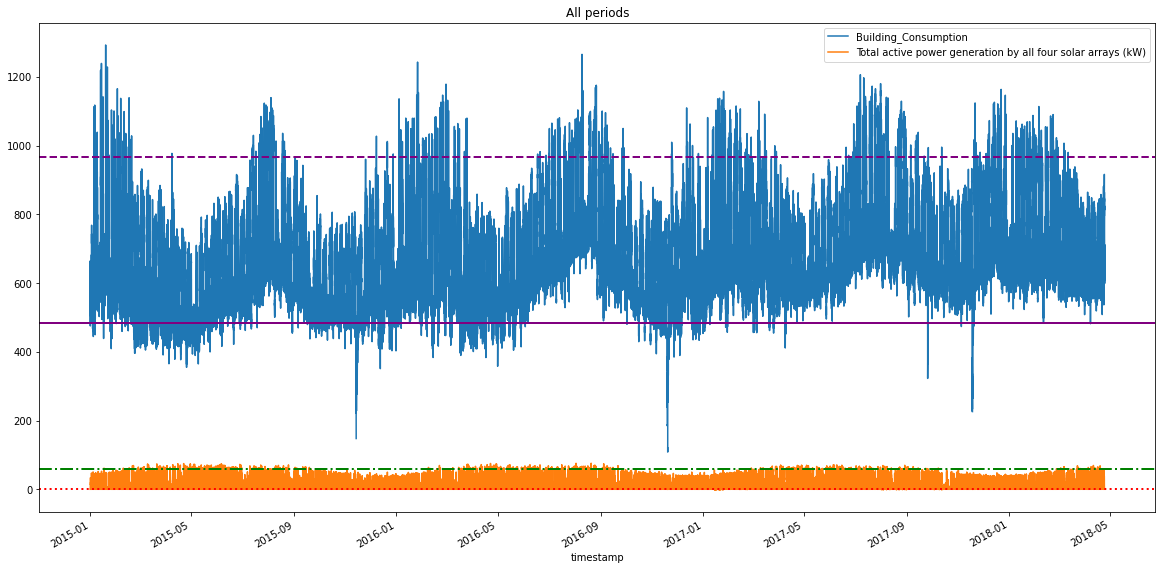

In [101]:
graph_production_consumption(df, 'All periods', fixed_quantiles=True)

### 2.1. Comparing each season, including lower and upper bounds used in Robust Instance generation (q10, q90)

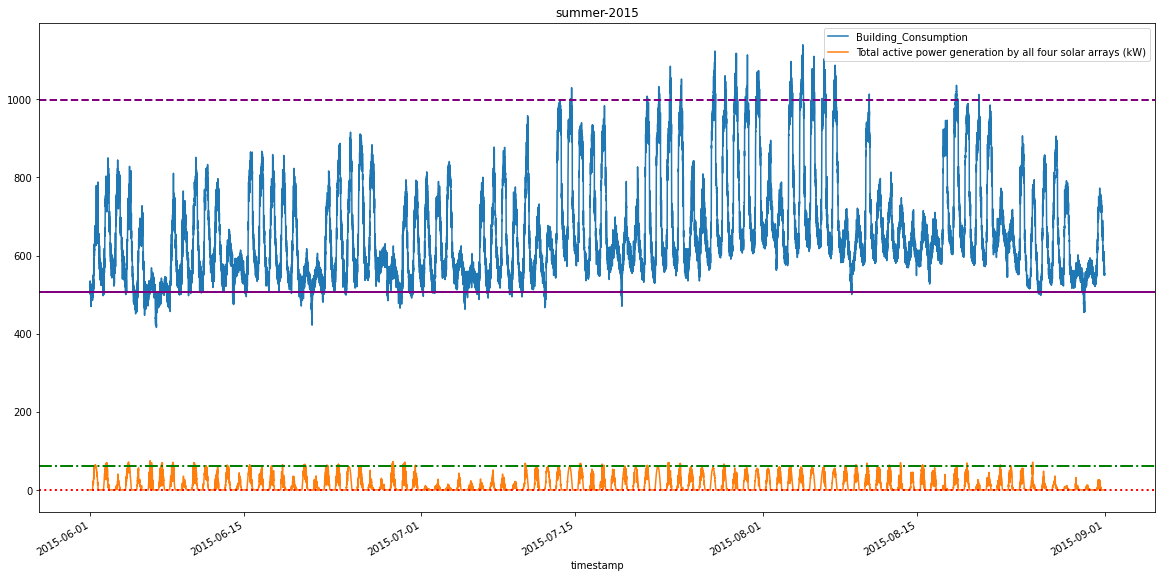

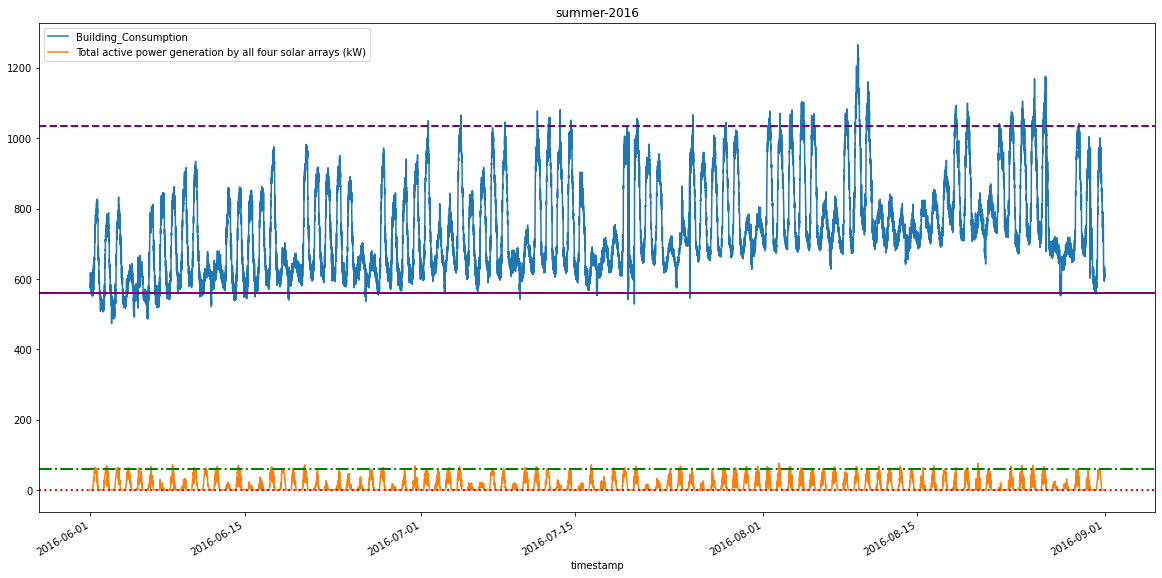

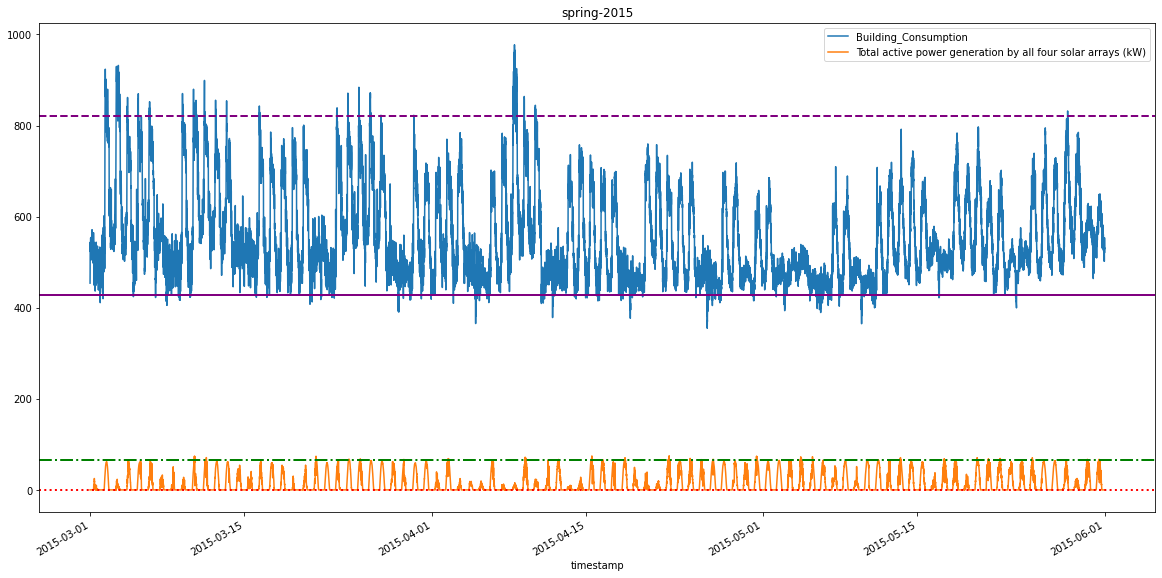

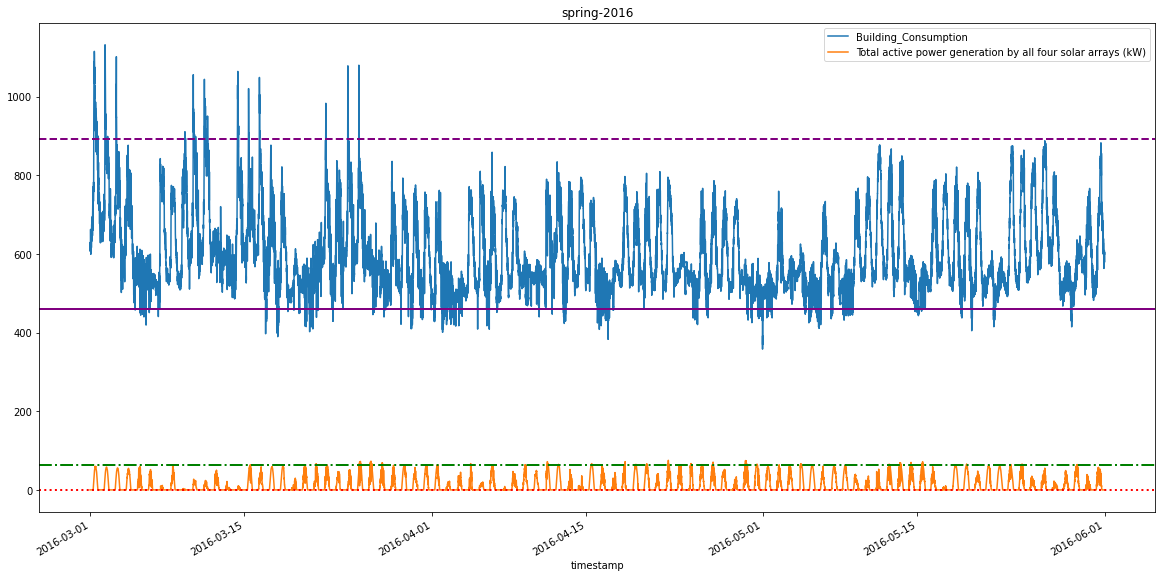

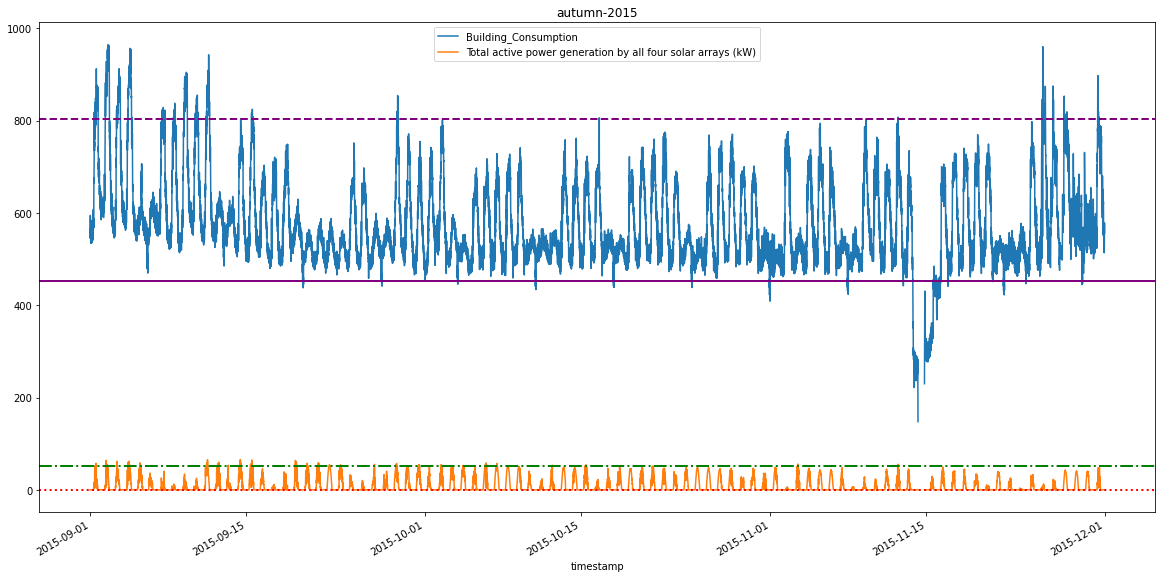

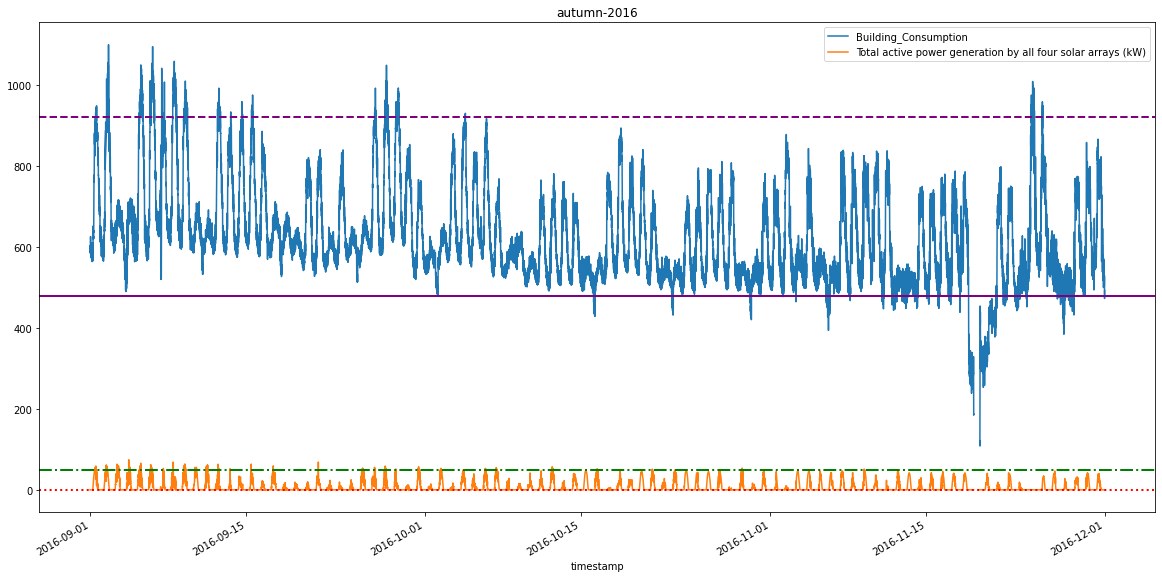

In [105]:
for season in ['summer', 'spring', 'autumn']:  # , 'winter']:
    for year in [2015, 2016]:
        if season == 'winter':
            month_list = [12, 1, 2]
            graph_production_consumption(df[(df.index >= ('%d-12-01' % year)) & (df.index < ('%d-03-01' % (year+1)))], '%s-%s' % (season, year))
        else:
            month_list = [x for x in range(start_month[season], end_month[season] + 1)]
            graph_production_consumption(df[(df.index.month.isin(month_list)) & (df.index.year == year)], '%s-%s' % (season, year))

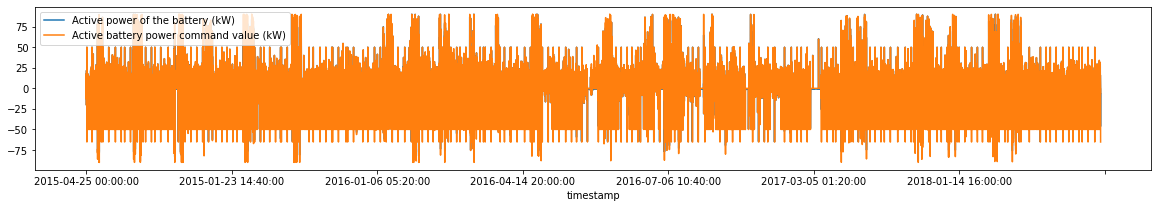

In [44]:
ax = df[['Active power of the battery (kW)', 'Active battery power command value (kW)']].plot(kind="line")
fig = ax.get_figure()
fig.set_size_inches(20, 3)

## 5. Graph with total energy consumption/production per month

In [28]:
df['month'] = df.index.month

In [29]:
df['year'] = df.index.year

In [30]:
df_monthly = pd.pivot_table(
    df, 
    values=['Building_Consumption', 'Total active power generation by all four solar arrays (kW)'],
    index="year",
    columns="month", 
    aggfunc=np.sum
)

In [32]:
df_monthly

Building_Consumption                                            \
month                   1             2             3             4    
year                                                                   
2015         -5.883404e+06 -5.134277e+06 -5.238286e+06 -4.692796e+06   
2016         -6.090652e+06 -5.472745e+06 -5.643288e+06 -4.996283e+06   
2017         -6.190320e+06 -5.773134e+06 -6.036397e+06 -5.520823e+06   
2018         -6.420301e+06 -5.904161e+06 -6.154167e+06 -4.541012e+06   

                                                                             \
month            5             6             7             8             9    
year                                                                          
2015  -4.786642e+06 -5.285100e+06 -6.082163e+06 -6.110182e+06 -5.207285e+06   
2016  -5.244434e+06 -5.810850e+06 -6.657328e+06 -7.184804e+06 -5.998645e+06   
2017  -5.820026e+06 -6.005140e+06 -7.169873e+06 -6.877758e+06 -6.014991e+06   
2018            NaN           NaN           NaN           NaN           NaN   

                     ...  \
month            10  ...   
year                 ...   
2015  -5.001751e+06  ...   
2016  -5.368721e+06  ...   
2017  -5.840474e+06  ...   
2018            NaN  ...   

      Total active power generation by all four solar arrays (kW)  \
month                                                          3    
year                                                                
2015                                       110615.198898            
2016                                        97027.013278            
2017                                        97150.128587            
2018                                        98745.301085            

                                                                   \
month             4              5              6              7    
year                                                                
2015   100214.914656  144620.037141  107055.455793  106649.886304   
2016   102265.826979  124649.594211   97605.090208  101505.453750   
2017   112381.791553  115092.766514  113330.080109  113768.755601   
2018    84172.508072            NaN            NaN            NaN   

                                                                              
month             8             9             10            11            12  
year                                                                          
2015    93944.101447  72072.479254  83708.288997  47201.659065  57665.269024  
2016   105952.389210  67132.050734  64677.853080  53404.670192  64672.996202  
2017    80274.418742  82003.311022  55181.414439  60255.423052  65535.633234  
2018             NaN           NaN           NaN           NaN           NaN  

[4 rows x 24 columns]

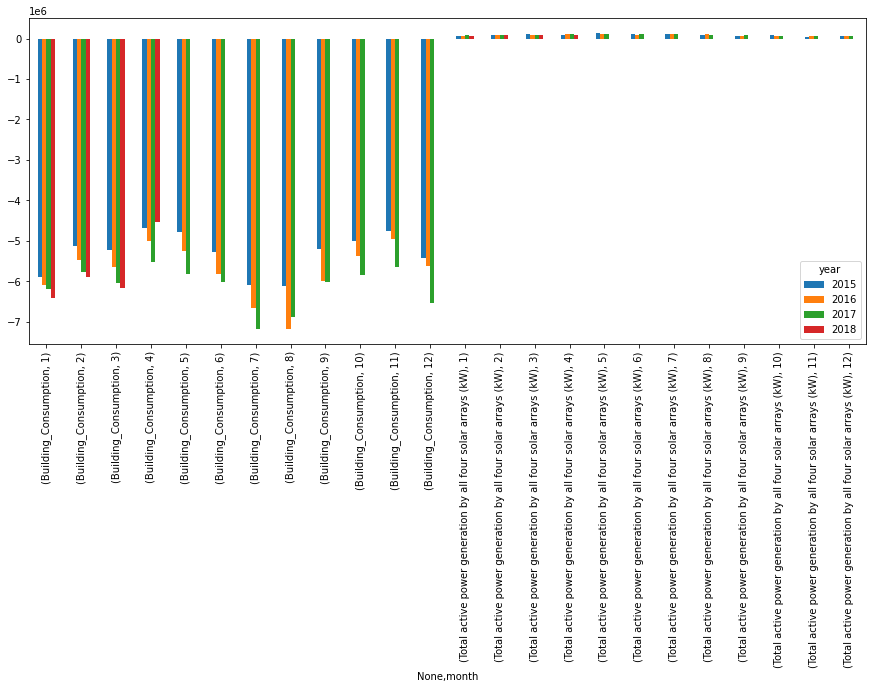

In [34]:
ax = df_monthly.T.plot(kind="bar", stacked=False)
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)